# Vehicle Detection Project

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

%matplotlib inline

## Load data

In [2]:
cars = []
notcars = []

# Divide up into cars and notcars
images = glob.glob('data/*/*/*.png')

for image in images:
    if 'vehicles' in image:
        cars.append(image)
    elif 'not-cars' in image:
        notcars.append(image)

print ( "Number of images containing cars:", len(cars))
print ( "Number of images not containing cars:", len(notcars))

Number of images containing cars: 8792
Number of images not containing cars: 8968


## Functions to extract features

In [3]:
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),  orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, vis=False):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion to YCrCb
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
   
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features


## Define parameters

In [4]:
# Define HOG parameters
orient = 12
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

# Spatial size and histogram parameters
spatial_size=(16, 16)
hist_bins=16

## Test and visualization HOG

Analyzing pictures:  data/vehicles/KITTI_extracted/2057.png
Analyzing pictures:  data/not-cars/GTI/image1462.png


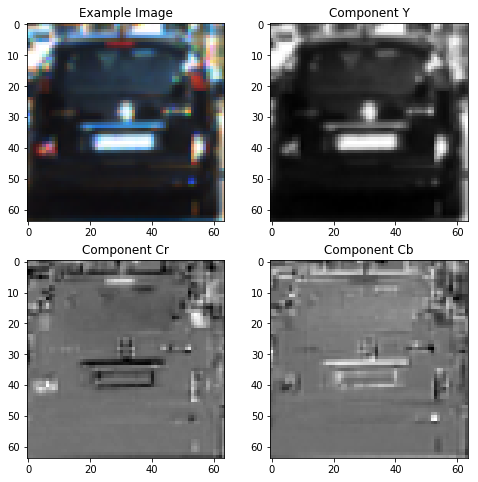

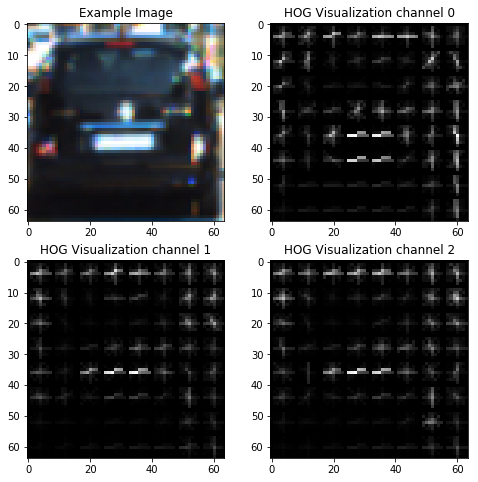

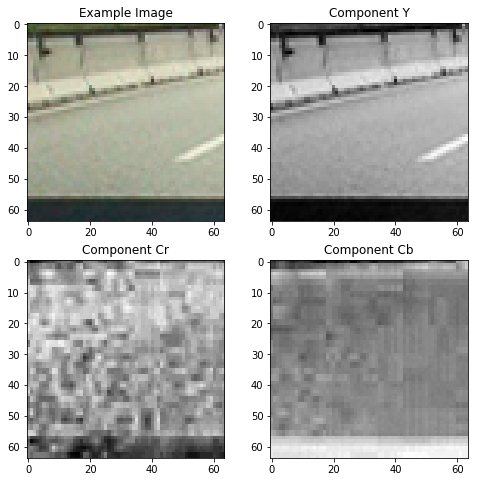

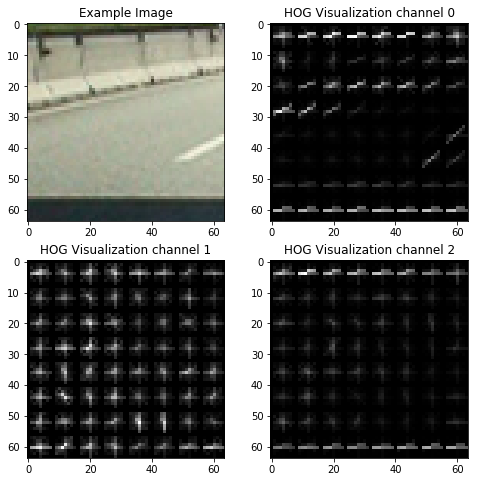

In [6]:
# Pick for two samples
images = [cars[0], notcars[0]]

for img_p in images:
    

    print ("Analyzing pictures: ", img_p)

    # Read in the image
    image = mpimg.imread(img_p)
    # Convert in YCrCb
    image_YCrCb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

    # Call our function with vis=True to see an image output
    hog_features = []
    hog_images = []
    for channel in range(image_YCrCb.shape[2]):
        features, hog_image = get_hog_features(image_YCrCb[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)
        hog_features.append(features)
        hog_images.append(hog_image)


    # Plot the examples
    fig = plt.figure(figsize = (8,8))
    plt.subplot(221)
    plt.imshow(image)
    plt.title('Example Image')
    plt.subplot(222)
    plt.imshow(image_YCrCb[:,:,0], cmap='gray')
    plt.title('Component Y')
    plt.subplot(223)
    plt.imshow(image_YCrCb[:,:,1], cmap='gray')
    plt.title('Component Cr')
    plt.subplot(224)
    plt.imshow(image_YCrCb[:,:,2], cmap='gray')
    plt.title('Component Cb')

    # Plot the examples
    fig = plt.figure(figsize = (8,8))
    plt.subplot(221)
    plt.imshow(image)
    plt.title('Example Image')
    plt.subplot(222)
    plt.imshow(hog_images[0], cmap='gray')
    plt.title('HOG Visualization channel 0')
    plt.subplot(223)
    plt.imshow(hog_images[1], cmap='gray')
    plt.title('HOG Visualization channel 1')
    plt.subplot(224)
    plt.imshow(hog_images[2], cmap='gray')
    plt.title('HOG Visualization channel 2')

## Extract Feature and Build Classifier

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import time
import pickle

print ('Extracting car features')
car_features = extract_features(cars, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
print ('Extracting not-car features')
notcar_features = extract_features(notcars, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',spatial_size, 'spatial_size' , hist_bins, 'hist_bins')
print('HOG: Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Extracting car features
Extracting not-car features
Using: (16, 16) spatial_size 16 hist_bins
HOG: Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7872
31.09 Seconds to train SVC...
Test Accuracy of SVC =  0.9904
My SVC predicts:  [ 0.  0.  1.  0.  1.  1.  1.  0.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  1.  1.  0.  0.  0.]
0.00406 Seconds to predict 10 labels with SVC


# Save data 

In [ ]:
# Save a dictionary into a pickle file.
import pickle

classifier_info = { "svc": svc, "scaler": X_scaler, "orient": orient, "pix_per_cell": pix_per_cell,
"cell_per_block": cell_per_block, "spatial_size": spatial_size, 'hist_bins': hist_bins }

pickle.dump( classifier_info, open( "classifier_info.p", "wb" ) )

#svc2 = joblib.load('svc_model.pkl') 
#n_predict = 10
#print('My SVC predicts: ', svc2.predict(X_test[0:n_predict]))
#print('For these',n_predict, 'labels: ', y_test[0:n_predict])

##  Extract features  and make prediction

In [8]:
from scipy.ndimage.measurements import label

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    draw_img_all_windows = np.copy(img)
    img = img.astype(np.float32)/255
    
    bbox_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch =  cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
 
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            cv2.rectangle(draw_img_all_windows,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bbox_list.append(((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return bbox_list, draw_img, draw_img_all_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Import classifier model and feature extraction settings

In [9]:
import pickle
# Load info
dist_pickle = pickle.load( open("classifier_info.p", "rb" ) )
svc_l = dist_pickle["svc"]
X_scaler_l = dist_pickle["scaler"]
orient_l = dist_pickle["orient"]
pix_per_cell_l = dist_pickle["pix_per_cell"]
cell_per_block_l = dist_pickle["cell_per_block"]
spatial_size_l = dist_pickle["spatial_size"]
hist_bins_l = dist_pickle["hist_bins"]

## Test on Images

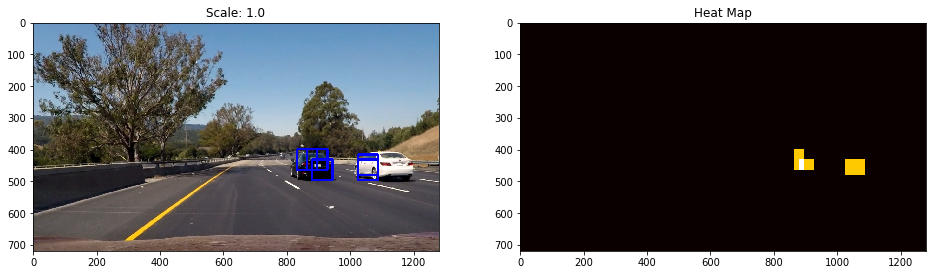

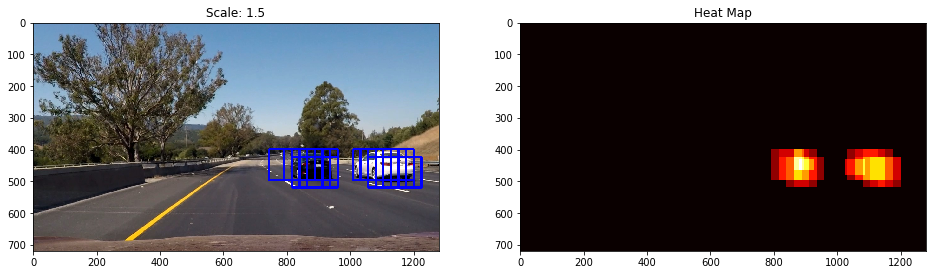

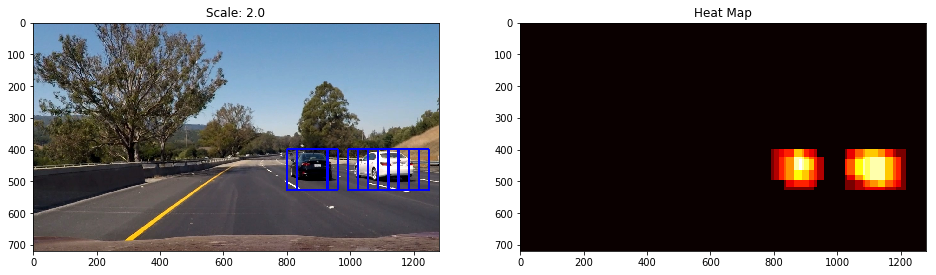

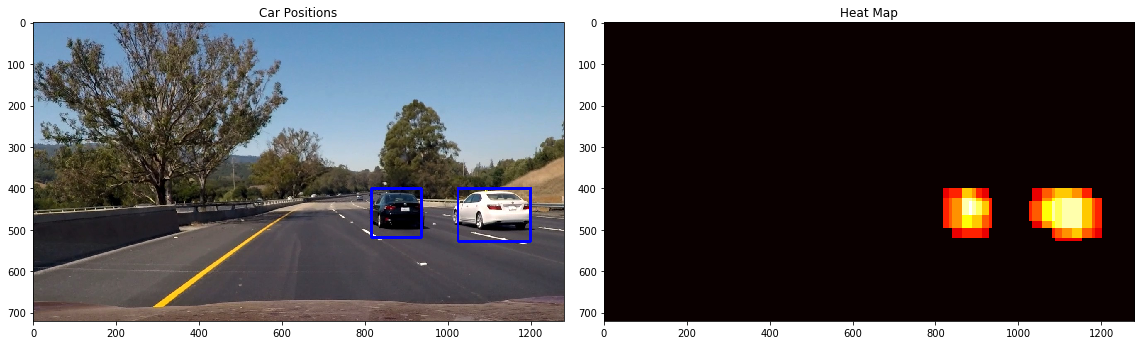

In [10]:
# Read an image to test
img = mpimg.imread('test_images/test6.jpg')
# Create the heat map
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Define ROI of the images where to use the sliding windows
ystart = 400
ystop = 656

# Look for cars at different scales
scales = [1., 1.5, 2.0]

for scale in scales:
    box_list,out_img,out_img_windows  = find_cars(img, ystart, ystop, scale, svc_l, X_scaler_l, orient_l, pix_per_cell_l, cell_per_block_l, spatial_size_l, hist_bins_l)
    heat = add_heat(heat,box_list)
    heat = apply_threshold(heat,1)

    fig = plt.figure(figsize = (16,16))
    plt.subplot(121)
    plt.imshow(out_img)
    caption = 'Scale: ' +  str(scale)
    plt.title(caption)
    plt.subplot(122)
    plt.imshow(heat, cmap='hot')
    plt.title('Heat Map')

# Apply threshold to help remove false positives
heat = apply_threshold(heat,3)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure(figsize = (16,16))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
#fig = plt.figure(figsize = (8,8))
#plt.imshow(out_img_windows)


## Test on a video

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import collections

heatmaps = collections.deque(maxlen=20)

def process_image(img):
    global heatmaps

    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    ystarts = [400,350,350]
    ystops = [656,570,570]
    
    # Look for cars at different scales
    scales = [1., 1.5, 2.0]

    for scale, ystart, ystop  in zip(scales,ystarts,ystops):
        box_list,out_img,out_img_windows  = find_cars(img, ystart, ystop, scale, svc_l, X_scaler_l, orient_l, pix_per_cell_l, cell_per_block_l, spatial_size_l, hist_bins_l)
        heat = add_heat(heat,box_list)
 
    heatmaps.append(heat)
    sum_heatmap = np.array(heatmaps).sum(axis=0)
    
    #fig = plt.figure(figsize = (8,8))
    #plt.imshow(heat, cmap='hot')
    
    heat = apply_threshold(sum_heatmap, min(len(heatmaps) * 2, 35)) #20

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

video_output = 'videos/project_video_out.mp4'
clip2 = VideoFileClip('videos/project_video.mp4')

video_clip = clip2.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)




## Play video result

In [ ]:

from IPython.display import HTML
video_output = 'videos/project_video_out.mp4'
print(video_output)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))